# 0. Import library

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler

# 1. Data

- Wikipeda에서 S&P500에 포함된 회사들의 리스트를 가져온다

In [2]:
sp500_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
data_table = pd.read_html(sp500_url)
tickers = data_table[0]['Symbol'].tolist()      # Ticker 이름
security = data_table[0]['Security'].tolist()   #Ticker 이름에 해당하는 회사 전체 이름
sector = data_table[0]['GICS Sector'].tolist()

- 기간 (2017.01.01 ~ 2023.01.01) 내에 데이터 없는 Ticker 이름 지우기

In [3]:
unused_tickers = ['BRK.B', 'BF.B', 'KVUE', 'VLTO']
unused_security = []
unused_sector = []

for idx, ticker in enumerate(tickers):
    if ticker in unused_tickers:
        unused_security.append(security[idx])
        unused_sector.append(sector[idx])

for ticker_item, sector_item, security_item in zip(unused_tickers, unused_sector, unused_security):
    tickers.remove(ticker_item)
    sector.remove(sector_item)
    security.remove(security_item)

- 데이터 불러오기. (2017.01.01 ~ 2023.01.01)

In [4]:
prices_list = []    # 주가
return_list = []    # 평균수익률
risk_list = []      # 변동성
volume_list = []    # 거래량

In [5]:
for ticker in tqdm(tickers):
    data = yf.download(ticker, start='2017-01-01', end='2023-01-01', progress=False)

    # 주가 데이터
    prices = pd.DataFrame(data['Adj Close'])
    prices.columns = [ticker]
    prices_list.append(prices)

    # 거래량 데이터
    volume = pd.DataFrame(data['Volume'])
    volume.columns = [ticker]
    volume_list.append(volume)

    # 변동성 데이터 (리스크)
    returns = prices.pct_change().fillna(0)
    risk = returns.std().values[0]
    return_list.append(returns.mean().values[0])
    risk_list.append(risk)

100%|██████████| 499/499 [05:44<00:00,  1.45it/s]


In [6]:
# 주가
prices_df = pd.concat(prices_list,axis=1).pct_change().fillna(0) # 수익률 변화 계산
prices_df = prices_df.iloc[1:].T    # Ticker명을 Index로 사용
prices_df.sort_index(inplace=True)
normalize = Normalizer()            # 데이터 정규화
prices_df = pd.DataFrame(normalize.fit_transform(prices_df), columns=prices_df.columns, index=prices_df.index)

# 거래량
volume_df = pd.concat(volume_list,axis=1).fillna(0)
volume_df = volume_df.iloc[1:].T    # Ticker명을 Index로 사용
volume_df.sort_index(inplace=True)

# 변동성 (리스크)
risk_df = pd.DataFrame(risk_list, columns=['Risk'], index=tickers).fillna(0)
risk_df.sort_index(inplace=True)

# 평균수익률
return_df = pd.DataFrame(return_list, columns=['Returns'], index=tickers).fillna(0)
return_df.sort_index(inplace=True)

- 여러 feature 의 조합으로 데이터 프레임 생성하기

In [7]:
df_list = []
features = [prices_df, volume_df, risk_df]
feature_names = ['prices', 'volume', 'risk']  # 각 특성의 이름

# 가능한 모든 특성 조합에 대해 클러스터링 수행
for r in range(1, len(features) + 1):
    for feature_indices in combinations(range(len(features)), r):
        df = pd.concat([features[i] for i in feature_indices], axis=1)
        df.name = ' & '.join([feature_names[i] for i in feature_indices])  # 데이터프레임의 이름 생성
        df_list.append(df)

# 2. K means Clustering

In [8]:
# DELETE ME
import warnings

# FutureWarning 숨기기
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


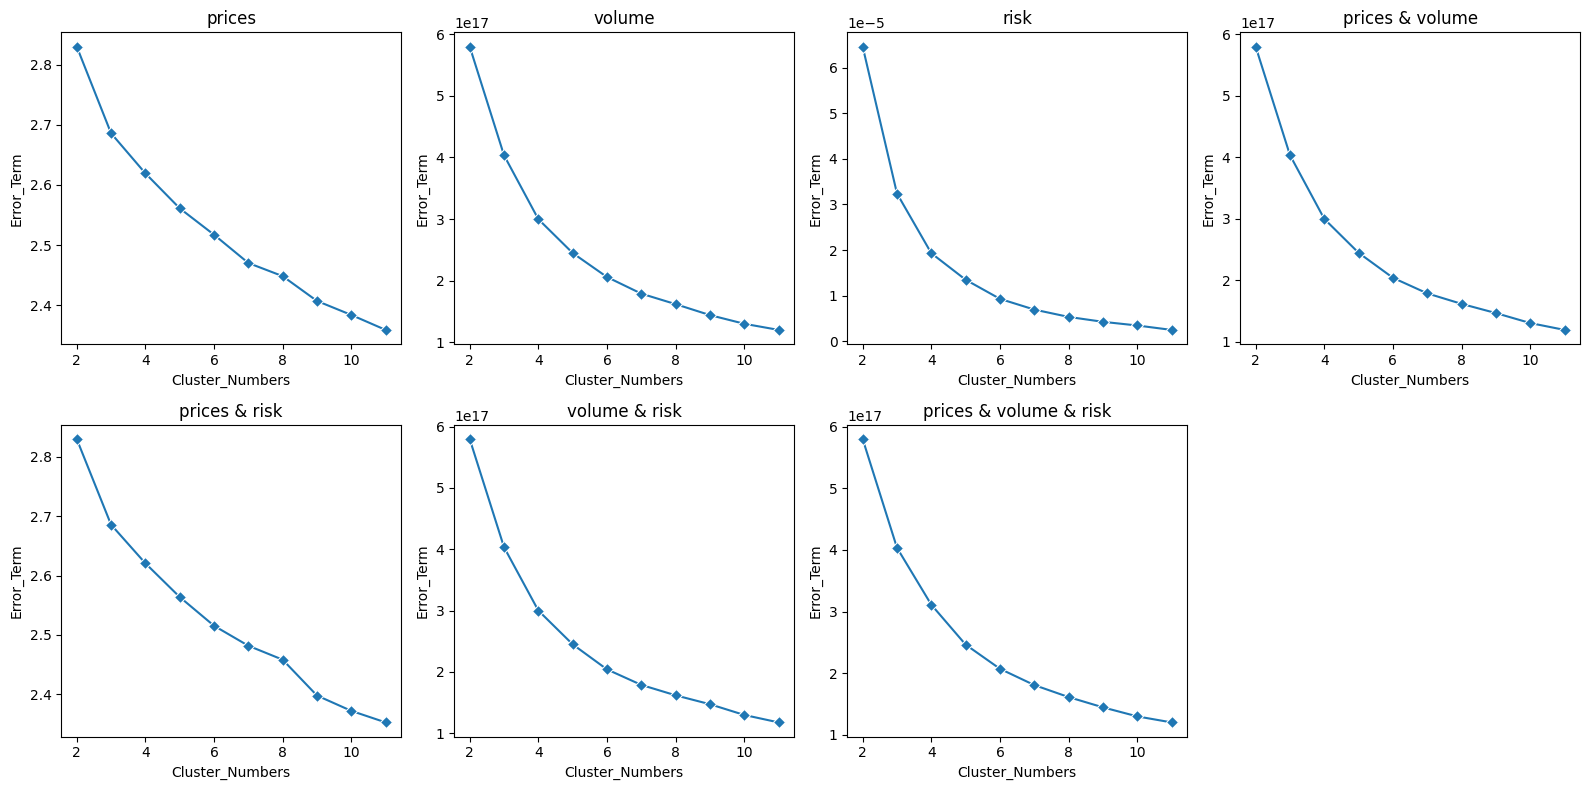

In [9]:
table_list = []
num_of_clusters = range(2,12)

fig, axes = plt.subplots((len(df_list) + 3) // 4, 4, figsize=(16, 4 * ((len(df_list) + 3) // 4)))

for i, final_df in enumerate(df_list):
    final_df.columns = final_df.columns.astype(str) # 칼럼 이름의 타입 : str

    error = []
    for num_clusters in tqdm(num_of_clusters):
        clusters = KMeans(num_clusters)
        clusters.fit(final_df)
        error.append(clusters.inertia_ / 100)
    table = pd.DataFrame({"Cluster_Numbers": num_of_clusters, "Error_Term": error})
    table['DataFrame'] = final_df.name
    table.set_index(['DataFrame', 'Cluster_Numbers'], inplace=True)  # MultiIndex 설정
    table_list.append(table)

    sns.lineplot(data=table, x='Cluster_Numbers', y='Error_Term', marker="D", ax=axes[i // 4, i % 4])
    axes[i // 4, i % 4].set_title(f'{final_df.name}')

for i in range(len(df_list), (len(df_list) + 3) // 4 * 4): # 빈 subplot은 숨기기
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

- 엘보우 방법으로 최적의 클러스터링 갯수를 찾는다.

In [10]:
elbow_list = []

for table in table_list:
    elbow_points = []
    final_df_name = table.index.levels[0][0]                                # MultiIndex에서 DataFrame 이름 가져오기

    sse = np.array(table.loc[(final_df_name, slice(None)), 'Error_Term'])   # MultiIndex 사용
    sse_diff = np.diff(sse)                                                 # SSE의 변화율 계산
    sse_diff2 = np.diff(sse_diff)                                           # 변화율의 변화율 계산

    min_length = len(sse) // 2                                              # (constraints) error term의 길이의 1/4
    elbow_point = np.argmax(sse_diff2[min_length:]) + min_length + 1        # 이계도함수가 가장 큰 지점 찾기 # 인덱스는 0부터 시작하므로 1을 더함
    elbow_points.append(elbow_point)

    max_elbow_point = max(elbow_points)
    print(f'{final_df_name} : The maximum elbow point is at {max_elbow_point} clusters.')
    elbow_list.append(max_elbow_point)

prices : The maximum elbow point is at 7 clusters.
volume : The maximum elbow point is at 8 clusters.
risk : The maximum elbow point is at 6 clusters.
prices & volume : The maximum elbow point is at 8 clusters.
prices & risk : The maximum elbow point is at 7 clusters.
volume & risk : The maximum elbow point is at 8 clusters.
prices & volume & risk : The maximum elbow point is at 8 clusters.


In [11]:
cluster_list = []
result_list = []

for idx, final_df in enumerate(df_list):
    # 최적의 클러스터링 개수만큼 클러스터 만들기
    elbow_point = elbow_list[idx]
    clusters = KMeans(elbow_point)
    clusters.fit(final_df)

    companies = list(final_df.index)
    movements = final_df.values
    labels = clusters.predict(movements)

    clustered_result = pd.DataFrame({'labels': labels, 'tickers': companies, 'full-name':security, 'sector':sector})
    clustered_result.sort_values('labels')
    cluster_list.append(clustered_result)

    final_df['Cluster'] = clusters.labels_
    result_list.append(final_df)

# 3. Result

### 1) Cluster

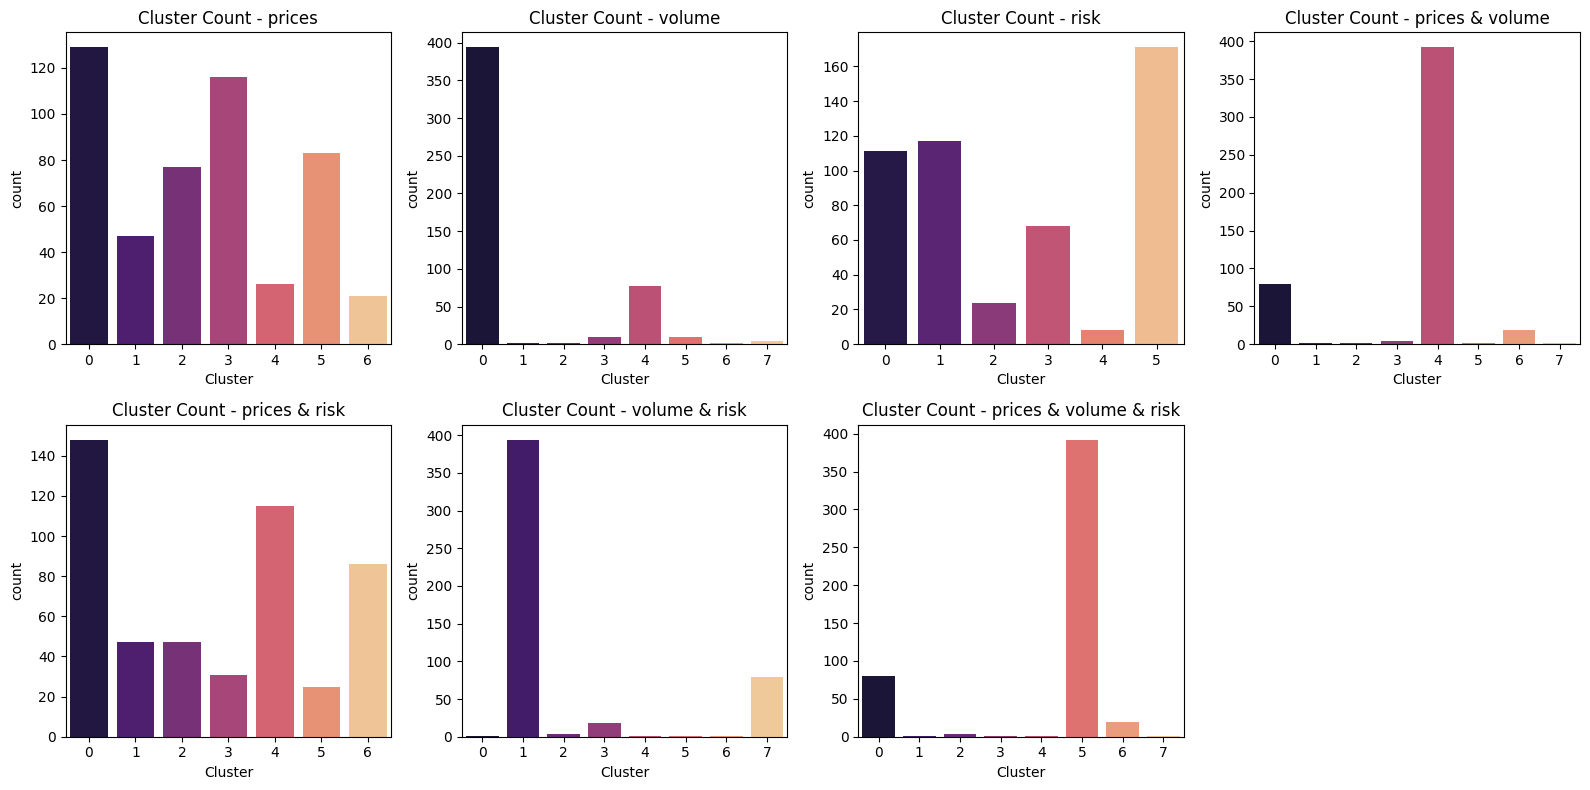

In [12]:
# Assuming you have a list of result_list
num_plots = len(result_list)
num_cols = 4  # Number of columns in the grid
num_rows = (num_plots - 1) // num_cols + 1  # Calculate the number of rows needed

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 4*num_rows))

# Flatten the axes array for easy indexing
axes = axes.flatten()

for i, final_df in enumerate(result_list):
    sns.countplot(x='Cluster', data=final_df, palette='magma', ax=axes[i])
    axes[i].set_title(f'Cluster Count - {final_df.name}')  # Assuming final_df has a 'name' attribute

# Hide any unused subplots
for j in range(num_plots, num_cols * num_rows):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### 2) Correlation

In [94]:
df_max_corr_dict = dict()
df_min_corr_dict = dict()
df_mean_corr_dict = dict()

for final_df in result_list:
  grouped_df = final_df.groupby('Cluster') # 'cluster' 칼럼을 기준으로 그룹화합니다.
  cluster_dfs = [pd.DataFrame(group) for _, group in grouped_df] # 각 그룹을 새로운 데이터프레임으로 만듭니다.
  clusters_corr_list = []
  for i, cluster1 in enumerate(cluster_dfs):
    average_cluster1 = cluster1.mean(axis=0) # 회사에 대해 평균
    cluster_corr_list = []
    for j, cluster2 in enumerate(cluster_dfs):
      if i == j:
        continue
      average_cluster2 = cluster2.mean(axis=0) # 회사에 대해 평균
      correlation_average_cluster = average_cluster1.corr(average_cluster2)
      cluster_corr_list.append(correlation_average_cluster)
    clusters_corr_list.append(sum(cluster_corr_list) / len(cluster_corr_list)) # 상관계수 평균
  df_max_corr_dict[final_df.name] = max(clusters_corr_list)
  df_min_corr_dict[final_df.name] = min(clusters_corr_list)
  df_mean_corr_dict[final_df.name] = sum(clusters_corr_list) / len(clusters_corr_list)

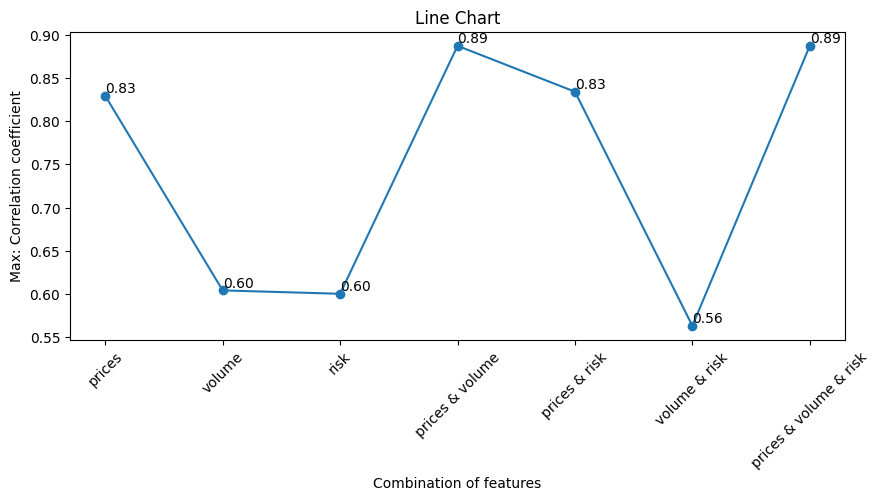

In [95]:
data = df_max_corr_dict
x_values = list(data.keys())
y_values = list(data.values())

plt.figure(figsize=(10, 4))
plt.plot(x_values, y_values, marker='o')

for x, y in zip(x_values, y_values):
    plt.text(x, y, f'{y:.2f}', ha='left', va='bottom')

plt.xticks(rotation=45)
plt.title('Line Chart')
plt.xlabel('Combination of features')
plt.ylabel('Max: Correlation coefficient')

plt.show()

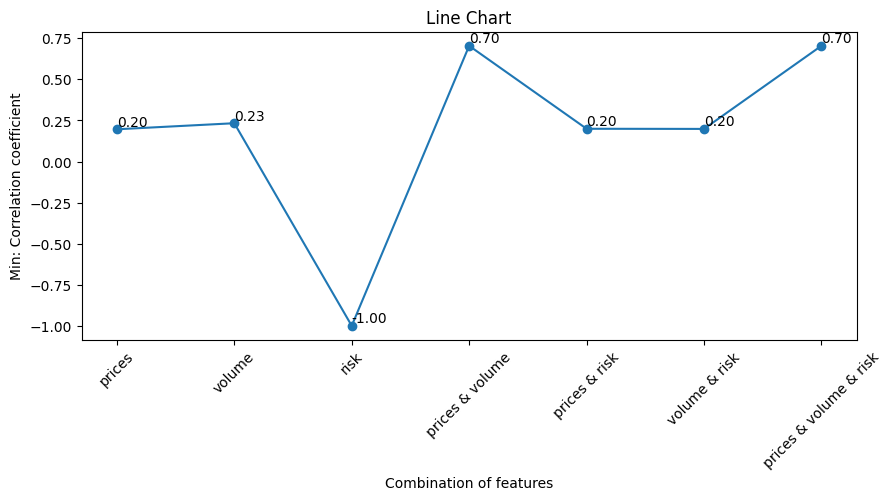

In [96]:
data = df_min_corr_dict
x_values = list(data.keys())
y_values = list(data.values())

plt.figure(figsize=(10, 4))
plt.plot(x_values, y_values, marker='o')

for x, y in zip(x_values, y_values):
    plt.text(x, y, f'{y:.2f}', ha='left', va='bottom')

plt.xticks(rotation=45)
plt.title('Line Chart')
plt.xlabel('Combination of features')
plt.ylabel('Min: Correlation coefficient')

plt.show()

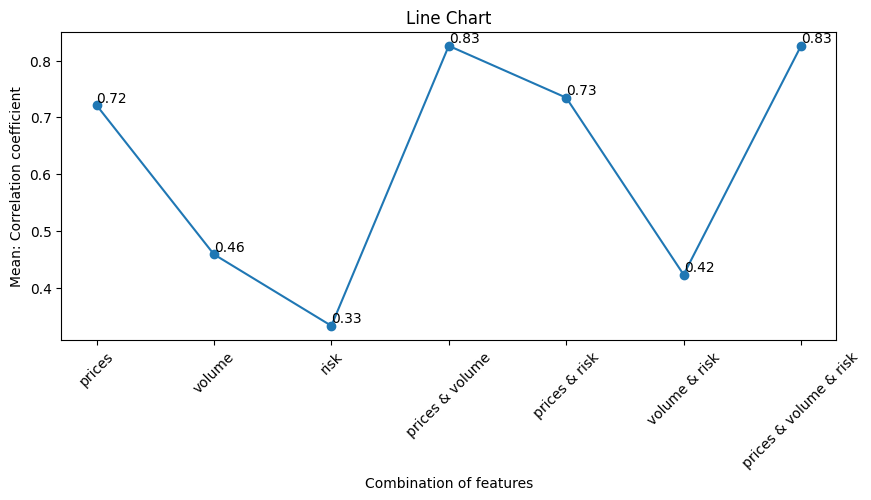

In [97]:
data = df_mean_corr_dict
x_values = list(data.keys())
y_values = list(data.values())

plt.figure(figsize=(10, 4))
plt.plot(x_values, y_values, marker='o')

for x, y in zip(x_values, y_values):
    plt.text(x, y, f'{y:.2f}', ha='left', va='bottom')

plt.xticks(rotation=45)
plt.title('Line Chart')
plt.xlabel('Combination of features')
plt.ylabel('Mean: Correlation coefficient')

plt.show()

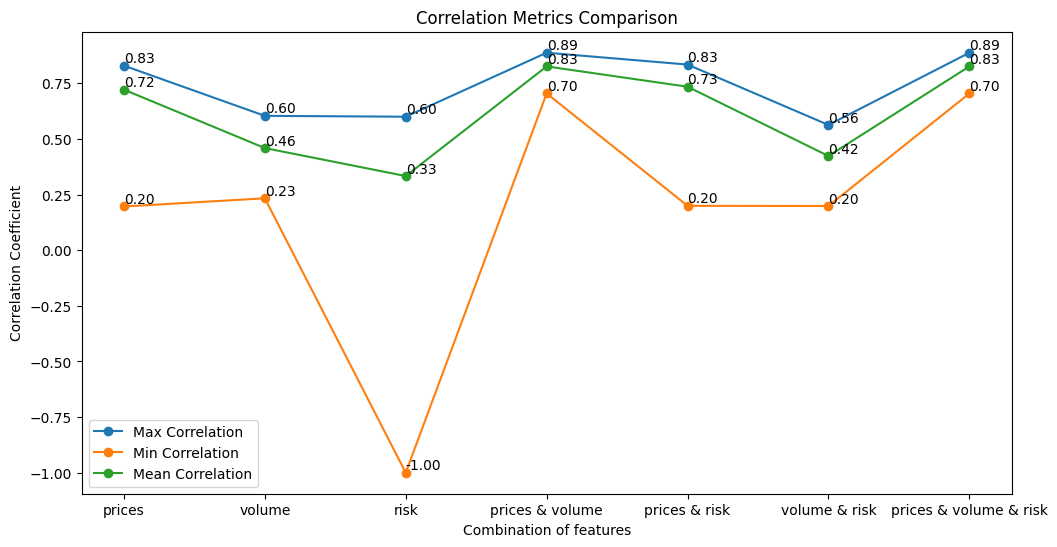

In [102]:
labels = list(df_max_corr_dict.keys())
max_values = list(df_max_corr_dict.values())
min_values = list(df_min_corr_dict.values())
mean_values = list(df_mean_corr_dict.values())

plt.figure(figsize=(12, 6))
plt.plot(labels, max_values, marker='o', label='Max Correlation')
plt.plot(labels, min_values, marker='o', label='Min Correlation')
plt.plot(labels, mean_values, marker='o', label='Mean Correlation')

for x, y_max, y_min, y_mean in zip(labels, max_values, min_values, mean_values):
    plt.text(x, y_max, f'{y_max:.2f}', ha='left', va='bottom')
    plt.text(x, y_min, f'{y_min:.2f}', ha='left', va='bottom')
    plt.text(x, y_mean, f'{y_mean:.2f}', ha='left', va='bottom')

plt.title('Correlation Metrics Comparison')
plt.xlabel('Combination of features')
plt.ylabel('Correlation Coefficient')

plt.legend()

plt.show()